In [204]:
import s3fs
import pandas as pd
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "jhajjar"
FILE_PATH_S3 = f"{MY_BUCKET}/Diffusion/post_processed_listings.csv"
with fs.open(FILE_PATH_S3, "r") as file_in:
    listings = pd.read_csv(file_in)

listings

,id,Type,Nb_chambre,loc,surface,prix
0,apimo-85473173,Appartement,1,Châtelet,29,364000
1,hektor-Les-4-Quartiers-383,Appartement,1,Châtelet,23,301000
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,Palais Royal,106,2490000
3,ag754594-448898324,Studio,1,Saint-Germain,27,365000
4,keller-williams-1-34_1_53-180645,Appartement,2,Vendôme,67,1190000
...,...,...,...,...,...,...
8825,apimo-6951400,Appartement,4,Plaine,89,599000
8826,apimo-6810785,Appartement,2,Gambetta,40,302000
8827,immo-facile-49166437,Appartement,3,Père Lachaise,67,769000
8828,immo-facile-48762452,Appartement,3,Télégraphe,57,519000


In [205]:
listings[listings['surface'] == 9]

,id,Type,Nb_chambre,loc,surface,prix
132,hektor-axihome-327,Appartement,1,Châtelet,9,119000
253,immo-facile-55760185,Appartement,1,Montorgueil,9,85000
662,ag755464-444399632,Studio,1,Monge,9,150000
696,immo-facile-57514044,Appartement,1,Rennes,9,75000
769,ag755553-445649108,Studio,1,Rennes,9,150000
...,...,...,...,...,...,...
7793,iad-france-1704362,Studio,1,Bassin de la Villette,9,101000
7808,ag922880-447180902,Appartement,1,Secrétan,9,89000
7852,iad-france-1697510,Studio,1,La Villette,9,52000
8269,laforet-immo-facile-22451826,Appartement,1,Gambetta,9,65000


Pour le moment nous enlevons les colonnes "id" et "loc" (qui sera traitée plus tard). De plus, nous créons une colonne prix/surface (i.e. le prix au mètre carré) qui sera notre variable objective à estimer. De plus, à des fins de comparaison, analyser simplement le prix n'a pas vraiment de sens sans prendre en compte la surface du bien.

In [206]:
listings = listings.drop(['id','loc'],axis=1)
listings.dropna(inplace=True)
listings["prix/surface"] = listings["prix"] / listings["surface"]



Afin de mieux appréhender notre dataframe, nous utilisons la fonction describe() de pandas. 

In [207]:
describe_table = listings.describe()
formatted_table = describe_table.applymap(lambda x: f"{x:.3f}")  # écriture non scientifique et 3 chiffres après la virgule pour améliorer la clarté.
formatted_table

/tmp/ipykernel_79539/4030609002.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_table = describe_table.applymap(lambda x: f"{x:.3f}")  # écriture non scientifique et 3 chiffres après la virgule pour améliorer la clarté.


,Nb_chambre,surface,prix,prix/surface
count,8830.000,8830.000,8830.000,8830.000
mean,2.884,68.405,792218.243,11013.540
std,1.862,53.165,878956.653,3540.779
min,1.000,4.000,22000.000,545.455
25%,2.000,33.000,330000.000,8950.000
50%,3.000,54.000,549040.000,10416.667
75%,4.000,87.000,900000.000,12307.692
max,90.000,699.000,20550000.000,52500.000


Avant d'interpréter les données, il est évident que plusieurs données résultent d'une anomalie/erreur de listing sur le site. En effet une propriété contiendrait 90 pièces est impossible, surtout à Paris. (il s'agit en effet d'une erreur uniquement sur cette caractéristique du bien). Nous supprimons la ligne associée à cette erreur. De même le prix minimum de 22 0000 euros parait impossible pour les types de biens que nous avons retenu

In [208]:
listings = listings.drop(index = listings['Nb_chambre'].idxmax())
listings = listings.drop(index = listings['prix'].idxmin())

In [209]:
describe_table = listings.describe()
formatted_table = describe_table.map(lambda x: f"{x:.3f}")  # écriture non scientifique et 3 chiffres après la virgule pour améliorer la clarté.
formatted_table

,Nb_chambre,surface,prix,prix/surface
count,8828.000,8828.000,8828.000,8828.000
mean,2.875,68.407,792168.678,11013.410
std,1.615,53.168,878923.987,3537.551
min,1.000,4.000,22000.000,545.455
25%,2.000,33.000,330000.000,8950.000
50%,3.000,54.000,549040.000,10416.667
75%,4.000,87.000,900000.000,12307.692
max,17.000,699.000,20550000.000,52500.000


Nous avons 8829 données, une taille convenable pour pouvoir étudier les comportements statistiques asymptotiques et disposer d'une certaine représentativité du marché immobilier parisien.
Le nombre de pièces disposant d'une médiane (3) et d'une moyenne (2.875) proches est centré autour de trois pièces. Ainsi, un immeuble représentatif parisien dispose (intuitivement) de deux chambres et un salon (la cuisine / salle de bains / toilettes / couloirs / entrée n'étant pas comptés). 
La surface moyenne et médiane sont quant à elles significativement éloignées. L'écart indique une distribution asymétrique vers la droite, quelques biens tirant la moyenne à la hausse. En effet un plancher minimal s'applique pour un bien immobilier (le minimum étant ici de 4m^2) tandis que le plafond peut être bien plus élevé (ici quasiment 700 m2 au maximum). D'un côte les studettes/locaux/caves sont nombreux mais de l'autre les grands appartements haussmanniens et l'immobilier de luxe compensent largement.
Le même raisonnement peut être appliqué pour le prix où l'on observe un écart de quasiment 250 000 euros à la hausse ce qui indique que la distribution est fortement asymétrique vers la droite. On observe un écart type encore plus élevé que la moyenne qui dévoile une variabilité très importante dans les données. le prix au m2 (prix/surface) étant une fonction du prix, hérite de ces distributions asymétrique bien que dans une faible mesure.
Nous avons donc des distributions fortement asymétriques à la hausse caractéristiques du marché immobilier parisien et que l'on retrouve dans d'autres centres économiques européens (comme Londres, Milan, Luxembourg, Genève, Bruxelles).

 Afin de diminuer l'importance des valeurs extrêmes nous utilisons une transformation logarithmique pour le prix.

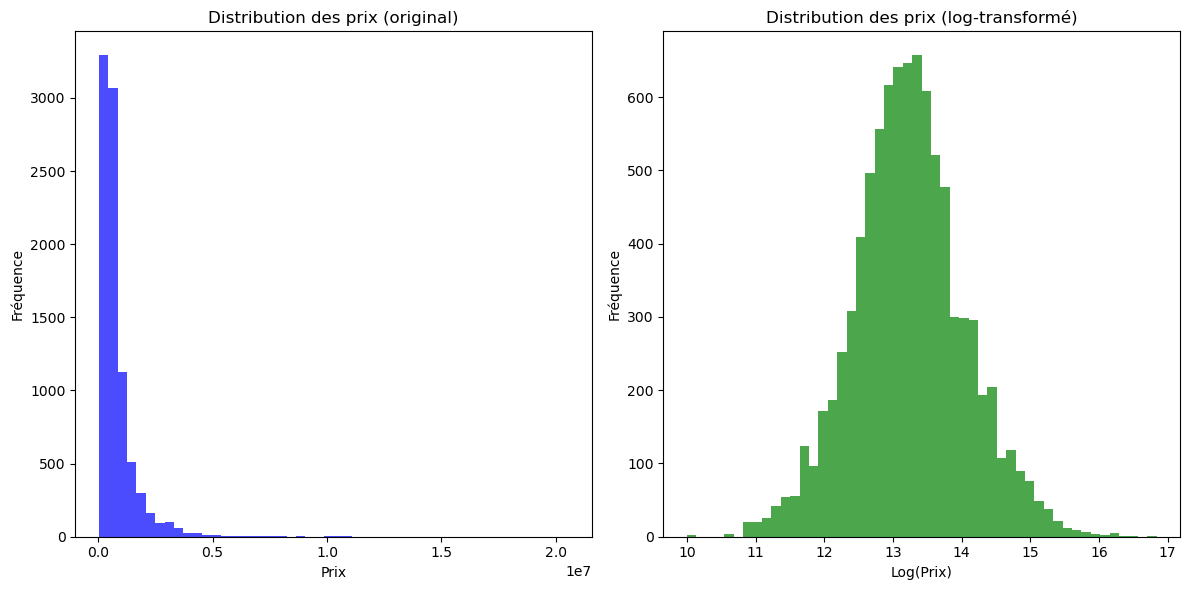

In [210]:
import numpy as np
import matplotlib.pyplot as plt
listings['log(prix)'] = np.log(listings['prix'])


# Histogramme avant transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Graphique 1
plt.hist(listings['prix'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution des prix (original)')
plt.xlabel('Prix')
plt.ylabel('Fréquence')

# Histogramme après transformation
plt.subplot(1, 2, 2)  # Graphique 2
plt.hist(listings['log(prix)'], bins=50, alpha=0.7, color='green')
plt.title('Distribution des prix (log-transformé)')
plt.xlabel('Log(Prix)')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()


In [211]:
listings = listings.drop('prix', axis=1)

Procédons maintenant à l'analyse descriptive graphique de nos différentes variables.
Pour la variable surface, examinons la distribution du type de bien immobilier.

Type
Appartement             8217
Studio                   303
Maison                   149
Duplex                   112
Loft/atelier/surface      46
Hôtel                      1
Name: count, dtype: int64


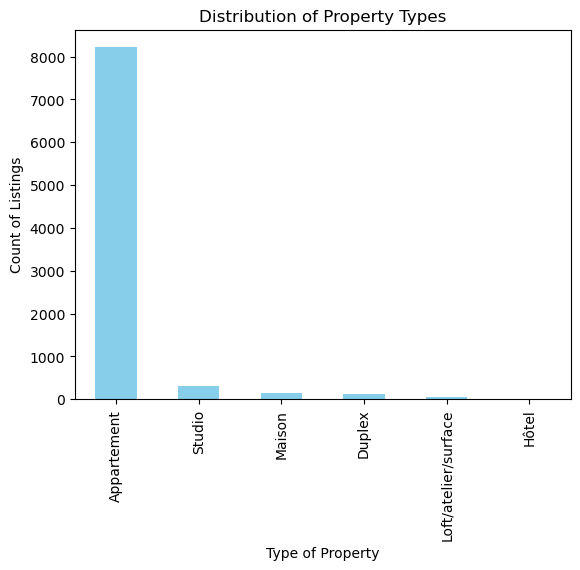

In [212]:
type_counts = listings['Type'].value_counts()
print(type_counts)

type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Property Types')
plt.xlabel('Type of Property')
plt.ylabel('Count of Listings')
plt.show()

Sans surprises, la grande majorité des biens offerts sont des appartements, héritages des travaux dirigés par le Baron Haussmann entre 1853 et 1870.  
Cependant les annonces étant remplies par des agences, elles sont sujettes à erreur, surtout pour la catégorisation des biens. Par exemple, pour les petites surfaces, on trouve un certain nombre de studios qui sont catégorisés en tant qu'appartements et inversement. La dénomination choisie de "studio" ne respecte souvent pas la réglementation française (Une surface habitable minimale de 9m, Une hauteur sous plafond d'au moins 2,20 mètres, Un volume habitable d'au moins 20m3).

Pour les autres types (hors Loft/atelier/surface), intuitivement, ils devraient ajouter de la valeur aux biens. En effet posséder une maison à Paris raisonne avec exclusivité, de même pour un Duplex (qui suppose une surface d'habitation plus importante que la moyenne) et dans une encore plus grande mesure pour un hôtel particulier.

In [213]:
listings[listings['surface'] == 9]

,Type,Nb_chambre,surface,prix/surface,log(prix)
132,Appartement,1,9,13222.222222,11.686879
253,Appartement,1,9,9444.444444,11.350407
662,Studio,1,9,16666.666667,11.918391
696,Appartement,1,9,8333.333333,11.225243
769,Studio,1,9,16666.666667,11.918391
...,...,...,...,...,...
7793,Studio,1,9,11222.222222,11.522876
7808,Appartement,1,9,9888.888889,11.396392
7852,Studio,1,9,5777.777778,10.858999
8269,Appartement,1,9,7222.222222,11.082143


array([[<Axes: xlabel='Nb_chambre', ylabel='Nb_chambre'>,
        <Axes: xlabel='surface', ylabel='Nb_chambre'>,
        <Axes: xlabel='prix/surface', ylabel='Nb_chambre'>,
        <Axes: xlabel='log(prix)', ylabel='Nb_chambre'>],
       [<Axes: xlabel='Nb_chambre', ylabel='surface'>,
        <Axes: xlabel='surface', ylabel='surface'>,
        <Axes: xlabel='prix/surface', ylabel='surface'>,
        <Axes: xlabel='log(prix)', ylabel='surface'>],
       [<Axes: xlabel='Nb_chambre', ylabel='prix/surface'>,
        <Axes: xlabel='surface', ylabel='prix/surface'>,
        <Axes: xlabel='prix/surface', ylabel='prix/surface'>,
        <Axes: xlabel='log(prix)', ylabel='prix/surface'>],
       [<Axes: xlabel='Nb_chambre', ylabel='log(prix)'>,
        <Axes: xlabel='surface', ylabel='log(prix)'>,
        <Axes: xlabel='prix/surface', ylabel='log(prix)'>,
        <Axes: xlabel='log(prix)', ylabel='log(prix)'>]], dtype=object)

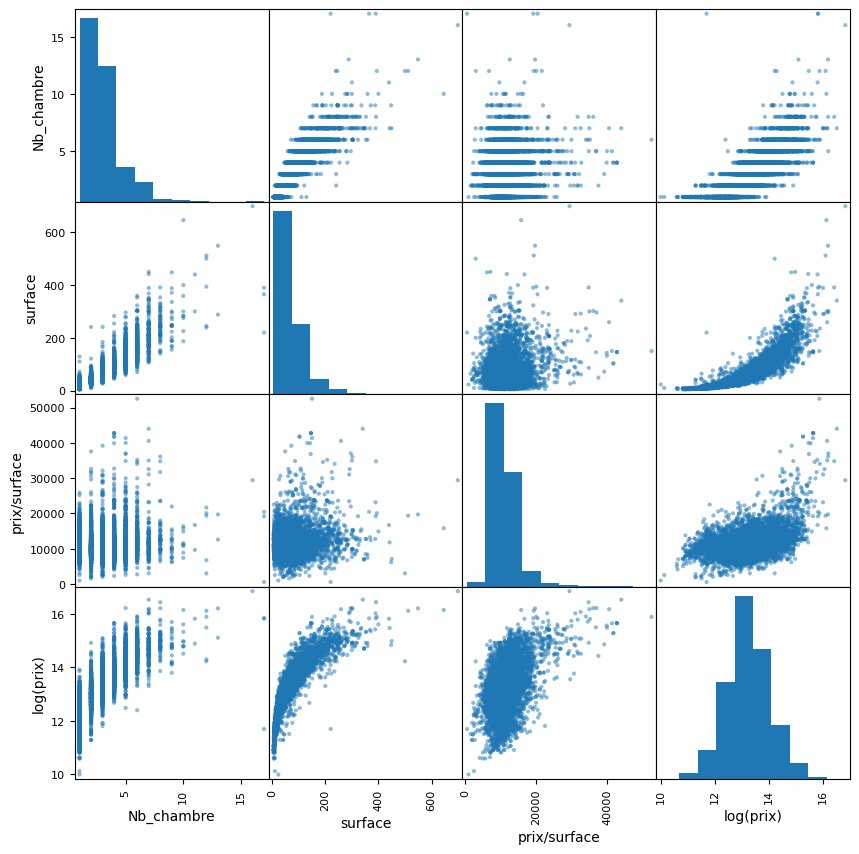

In [214]:
pd.plotting.scatter_matrix(listings,figsize=(10, 10))

In [215]:

listings = listings[listings["Nb_chambre"]<50]
listings["prix/surface par pièce"] = listings["prix/surface"]/listings["Nb_chambre"]
quantile_sup_psp = listings["prix/surface par pièce"].quantile(0.95)
quantile_inf_psp = listings["prix/surface par pièce"].quantile(0.05)
quantile_sup_ps = listings["prix/surface"].quantile(0.95)
quantile_inf_ps = listings["prix/surface"].quantile(0.05)
quantile_sup_p = listings["prix/surface"].quantile(0.95)
quantile_inf_p = listings["prix/surface"].quantile(0.05)
listings = listings[(listings["prix/surface par pièce"]>=quantile_inf_psp) & (listings["prix/surface par pièce"]>=quantile_inf_psp)]
listings = listings[(listings["prix/surface"]>=quantile_inf_ps) & (listings["prix/surface"]>=quantile_inf_ps)]
listings = listings[(listings["prix/surface"]>=quantile_inf_p) & (listings["prix/surface"]>=quantile_inf_p)]
#pd.plotting.scatter_matrix(listings)

listings[listings["Nb_chambre"]>14]

,Type,Nb_chambre,surface,prix/surface,log(prix),prix/surface par pièce
5408,Appartement,16,699,29399.141631,16.838371,1837.446352


array([[<Axes: xlabel='Nb_chambre', ylabel='Nb_chambre'>,
        <Axes: xlabel='surface', ylabel='Nb_chambre'>,
        <Axes: xlabel='prix/surface', ylabel='Nb_chambre'>,
        <Axes: xlabel='log(prix)', ylabel='Nb_chambre'>,
        <Axes: xlabel='prix/surface par pièce', ylabel='Nb_chambre'>],
       [<Axes: xlabel='Nb_chambre', ylabel='surface'>,
        <Axes: xlabel='surface', ylabel='surface'>,
        <Axes: xlabel='prix/surface', ylabel='surface'>,
        <Axes: xlabel='log(prix)', ylabel='surface'>,
        <Axes: xlabel='prix/surface par pièce', ylabel='surface'>],
       [<Axes: xlabel='Nb_chambre', ylabel='prix/surface'>,
        <Axes: xlabel='surface', ylabel='prix/surface'>,
        <Axes: xlabel='prix/surface', ylabel='prix/surface'>,
        <Axes: xlabel='log(prix)', ylabel='prix/surface'>,
        <Axes: xlabel='prix/surface par pièce', ylabel='prix/surface'>],
       [<Axes: xlabel='Nb_chambre', ylabel='log(prix)'>,
        <Axes: xlabel='surface', ylabel='log(

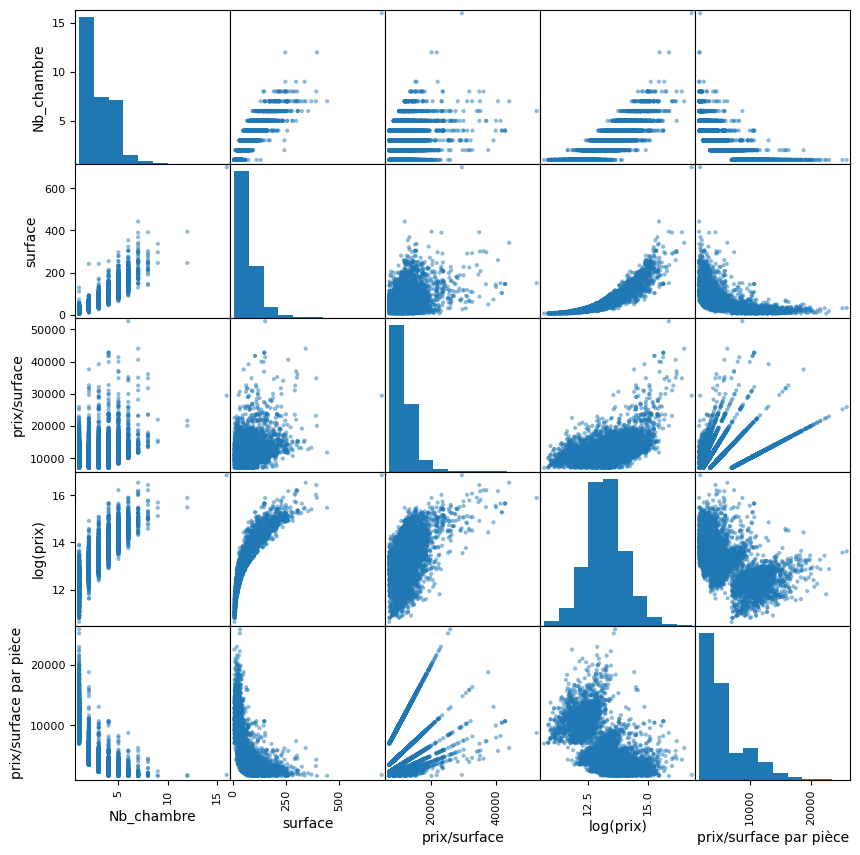

In [216]:
listings.dropna(inplace=True)

pd.plotting.scatter_matrix(listings,figsize=(10, 10))


Description des colonnes "number of rooms", "sqm2" et "price"

In [217]:
listings[['Nb_chambre', 'surface', 'prix']].describe().round(2)


KeyError: "['prix'] not in index"

Le sample est donc de 9358 observations ce qui nous permet de faire des interprétations sans se baser sur un échantillon qui manquerait de représentativité. Cependant la ville de Paris sur laquelle nous nous focalisons comporte en elle-même un biais par rapport aux autres villes françaises(centre économique, centre politique, centre culturel et dimension internationale).
La moyenne (806 740€) est sensiblement plus élevé que la médiane (565 000€) ce qui suppose que la distribution de prix est biaisé. Le prix de quelques propriétés tirent à la hausse la moyenne. Cela peut paraître logique, la ville de Paris étant connu pour son immobilier de luxe, prisée par des investisseurs internationaux. Le maximum de 20 millions d'euros confirme cette disparité dans les prix.

In [ ]:
listings["price/sqm2"] = listings["price"] / listings["sqm2"]
listings = listings[listings["price/sqm2"]>4500]
listings = listings[listings['Type'] != 'Loft/atelier/surface']
listings[['Number_of_rooms', 'sqm2', 'price','price/sqm2']].describe().round(2)


KeyError: 'price'